<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/1404_08_07_2_sensor_2_state(multi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [210]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [211]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [212]:
!ls "/content/drive/My Drive/ASCE"

shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [213]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        channels = []
        for f in raw._fieldnames:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)  # (n_samples, n_channels)
    else:
        raise ValueError("Unexpected MAT structure. 'dasy' not a struct.")
    return data  # float64 by default

base_dir = '/content/drive/MyDrive/ASCE/'
state_files = {
    1: 'shm01a.mat', 2: 'shm02a.mat', 3: 'shm03a.mat',
    4: 'shm04a.mat', 5: 'shm05a.mat', 6: 'shm06a.mat',
    7: 'shm07a.mat', 8: 'shm08a.mat', 9: 'shm09a.mat',
}
# label_to_class_id: 1..9 -> 0..8
label_to_cid = {lab: i for i, lab in enumerate(sorted(state_files.keys()))}

scenario_data = {}   # cid -> np.ndarray [N, C]
for lab, fname in state_files.items():
    x = load_mat(os.path.join(base_dir, fname)).astype(np.float32)
    scenario_data[label_to_cid[lab]] = x
print(scenario_data[0][:,:].shape)
print(scenario_data[0][:,4].shape)
print(scenario_data[4][:,4].shape)
    # print(fname, x.shape)

(60000, 16)
(60000,)
(60000,)


In [214]:
# print(scenario_data[0][:,4].shape)
# print(scenario_data[0][:,4])
# print('Max = ',max(scenario_data[0][:,4]))
# print('Min = ',min(scenario_data[0][:,4]))
# fig , axs = plt.subplots(2,3,figsize=(10,5))
# axs[0,0].plot(scenario_data[0][:win,4])
# axs[0,1].plot(scenario_data[0][win: 2*win,4])
# axs[0,2].plot(scenario_data[0][:,4])

# print(scenario_data[1][:,4].shape)
# print('Max = ',max(scenario_data[1][:,4]))
# print('Min = ',min(scenario_data[1][:,4]))
# axs[1,0].plot(scenario_data[1][:win,4],c='r')
# axs[1,1].plot(scenario_data[1][win:2*win,4], c='r')
# axs[1,2].plot(scenario_data[1][:,4],c='r')


In [215]:
healthy_data_1 = scenario_data[0][:,4]
healthy_data_2 = scenario_data[0][:,6]
Healthy_data = np.stack([healthy_data_1, healthy_data_2], axis = 1)
print(Healthy_data.shape)

damaged_data_1 = scenario_data[7][:,4]
damaged_data_2 = scenario_data[7][:,6]
Damaged_data = np.stack([damaged_data_1, damaged_data_2], axis = 1)
print(Damaged_data.shape)


(60000, 2)
(180000, 2)


In [216]:
def make_windows(data, window_length, drop_last : bool = True):
    # Calculate how many full frames can be created
    num_frames = len(data) // window_length
    # print(num_frames)
    # Trim the data to be a perfect multiple of the frame length
    trimmed_data = data[:num_frames * window_length]

    # Reshape the data into a 2D array of frames
    windows = trimmed_data.reshape((num_frames, window_length))
    # return trimmed_data.shape , frames.shape
    return windows

In [217]:
def make_windows_stride(x, win, stride):
    n = 1 + (len(x) - win)//stride
    idx = np.arange(win)[None,:] + stride*np.arange(n)[:,None]
    return x[idx]


In [218]:
win = 1024
stride = 512

# # Build windows per sensor (shape: [N_win, 128])
# h_1 = make_windows(healthy_data_1, win)
# h_2 = make_windows(healthy_data_2, win)
# d_1 = make_windows(damaged_data_1, win)
# d_2 = make_windows(damaged_data_2, win)

# Build windows per sensor (shape: [N_win, 128])
h_1 = make_windows(healthy_data_1, win, stride)
h_2 = make_windows(healthy_data_2, win, stride)
d_1 = make_windows(damaged_data_1, win, stride)
d_2 = make_windows(damaged_data_2, win, stride)

# WRONG before: np.concatenate([...], axis=1) -> (N, 256)  # mixes time with channels
# RIGHT: stack as channels -> (N, 128, 2)
healthy_data = np.stack([h_1, h_2], axis=-1)  # (N_h, 128, 2)
damaged_data = np.stack([d_1, d_2], axis=-1)  # (N_d, 128, 2)

print(healthy_data.shape) # Should be (468, 128, 2)
print(damaged_data.shape) # Should be (468, 128, 2)


(58, 1024, 2)
(175, 1024, 2)


In [219]:
# win = 128

# # Sensor 1 data from healthy (h_1) and damaged (d_1)
# h_1 = make_windows(scenario_data[0][:,4], win, drop_last=True) # (468, 128)
# d_1 = make_windows(scenario_data[1][:,4], win, drop_last=True) # (468, 128)

# # Sensor 2 data from healthy (h_2) and damaged (d_2)
# h_2 = make_windows(scenario_data[0][:,6], win, drop_last=True) # (468, 128)
# d_2 = make_windows(scenario_data[1][:,6], win, drop_last=True) # (468, 128)

# # Stack the two sensors along a new axis (the feature/channel axis)
# # Resulting shape: (N_windows, window_length, N_channels) -> (468, 128, 2)
# healthy_data = np.stack([h_1, h_2], axis=2)
# damaged_data = np.stack([d_1, d_2], axis=2)

# print(healthy_data.shape) # Should be (468, 128, 2)
# print(damaged_data.shape) # Should be (468, 128, 2)

In [220]:
# # 2) Make windows per class
# h_1 = make_windows(healthy_data_1, win, drop_last=True)
# h_2 = make_windows(healthy_data_2, win, drop_last=True)

# print(h_1)
# print(h_2)
# print(h_1.shape)
# print(h_2.shape)


# healthy_data = np.concatenate([h_1,h_2], axis = 1)
# print(healthy_data.shape)
# # print(healthy_data)

# d_1 = make_windows(damaged_data_1, win, drop_last=True)
# d_2 = make_windows(damaged_data_2, win, drop_last=True)
# damaged_data = np.concatenate([d_1,d_2], axis = 1)

# print(damaged_data.shape)



In [221]:
n_train, n_val = 0.6, 0.2
print(len(healthy_data))
m_0, l_0 = int(n_train*len(healthy_data)), int(n_val*len(healthy_data))
m_1, l_1 = int(n_train*len(damaged_data)), int(n_val*len(damaged_data))

X_train_0, X_val_0, X_test_0 = healthy_data[:m_0], healthy_data[m_0:m_0+l_0], healthy_data[m_0+l_0:]
X_train_1, X_val_1, X_test_1 = damaged_data[:m_1], damaged_data[m_1:m_1+l_1], damaged_data[m_1+l_1:]

# concat train sets to compute stats (axis=(0,1) => over samples and time; keep channel-wise stats)
train_all = np.concatenate([X_train_0, X_train_1], axis=0)       # (N_tr, 128, 2)
mu  = train_all.mean(axis=(0,1), keepdims=True)                   # (1,1,2)
std = train_all.std(axis=(0,1), keepdims=True) + 1e-6             # (1,1,2)

def norm(x): return (x - mu)/std
X_train_0, X_val_0, X_test_0 = norm(X_train_0), norm(X_val_0), norm(X_test_0)
X_train_1, X_val_1, X_test_1 = norm(X_train_1), norm(X_val_1), norm(X_test_1)

print(X_train_0.shape)
print(X_val_0.shape)
print(X_test_0.shape)
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape )


58
(34, 1024, 2)
(11, 1024, 2)
(13, 1024, 2)
(105, 1024, 2)
(35, 1024, 2)
(35, 1024, 2)


In [222]:
# n_train = 0.6
# n_val = 0.2

# m_0 = int(n_train * (healthy_data.shape[0]))
# print(healthy_data.shape[0])
# print(m_0)
# l_0 = int(n_val * (healthy_data.shape[0]))

# m_1 = int(n_train * (damaged_data.shape[0]))
# print(damaged_data.shape[0])
# print(m_1)
# l_1 = int(n_val * (damaged_data.shape[0]))

# X_train_0 = healthy_data[0:m_0,:]
# print('X_train_0',X_train_0.shape)
# X_val_0 = healthy_data[m_0 :m_0+l_0,:]
# print('X_val_0',X_val_0.shape)
# X_test_0 = healthy_data[m_0+l_0:,:]
# print('X_test_0',X_test_0.shape)

# y_0 = np.zeros((X_train_0.shape[0]+X_val_0.shape[0]+X_test_0.shape[0]), dtype=np.int64)
# print(y_0.shape)

# X_train_1 = damaged_data[0:m_1,:]
# X_val_1 = damaged_data[m_1 :m_1+l_1,:]
# X_test_1 = damaged_data[m_1+l_1:,:]
# y_1 = np.ones((X_train_1.shape[0]+X_val_1.shape[0]+X_test_1.shape[0]), dtype=np.int64)
# print(y_1.shape)

In [223]:
print('x_train_o.shape:', X_train_0.shape)
print('x_val_o.shape:', X_val_0.shape)
print('x_test_o.shape:', X_test_0.shape)

x_train_o.shape: (34, 1024, 2)
x_val_o.shape: (11, 1024, 2)
x_test_o.shape: (13, 1024, 2)


In [224]:
print('x_train_1.shape:', X_train_1.shape)
print('x_val_1.shape:', X_val_1.shape)
print('x_test_1.shape:', X_test_1.shape)


x_train_1.shape: (105, 1024, 2)
x_val_1.shape: (35, 1024, 2)
x_test_1.shape: (35, 1024, 2)


In [225]:
X_train = np.concatenate([X_train_0, X_train_1], axis=0)  # (N, 128, 2)
y_train = np.array([0]*len(X_train_0) + [1]*len(X_train_1), dtype=np.int64)

X_val = np.concatenate([X_val_0, X_val_1], axis=0)        # (N, 128, 2)
y_val = np.array([0]*len(X_val_0) + [1]*len(X_val_1), dtype=np.int64)

X_test = np.concatenate([X_test_0, X_test_1], axis=0)     # (N, 128, 2)
y_test = np.array([0]*len(X_test_0) + [1]*len(X_test_1), dtype=np.int64)

# shuffle train only
rng = np.random.default_rng(42)
perm = rng.permutation(len(X_train))
X_train, y_train = X_train[perm], y_train[perm]

# to torch
X_train = torch.from_numpy(X_train).float()   # [N, 128, 2]
X_val   = torch.from_numpy(X_val).float()
X_test  = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_val   = torch.from_numpy(y_val).long()
y_test  = torch.from_numpy(y_test).long()


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


torch.Size([139, 1024, 2]) torch.Size([139])
torch.Size([46, 1024, 2]) torch.Size([46])
torch.Size([48, 1024, 2]) torch.Size([48])


In [226]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X  # [N, seq_len, 1]
        self.y = y  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
# print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

In [227]:
# 6) DataLoaders: shuffle only the training set
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [228]:
with torch.no_grad():
    ys_tr = torch.cat([yb.view(-1) for _, yb in train_loader], dim=0).cpu()
    ys_va = torch.cat([yb.view(-1) for _, yb in val_loader], dim=0).cpu()

print("train label set/counts:", ys_tr.unique(return_counts=True))
print("val   label set/counts:", ys_va.unique(return_counts=True))
print("train min/max:", ys_tr.min().item(), ys_tr.max().item())
print("val   min/max:", ys_va.min().item(), ys_va.max().item())

train label set/counts: (tensor([0, 1]), tensor([ 34, 105]))
val   label set/counts: (tensor([0, 1]), tensor([11, 35]))
train min/max: 0 1
val   min/max: 0 1


In [229]:
# 7) Example: adapt a batch for a Transformer [seq_len, batch, d_model]
xb, yb = next(iter(train_loader))   # xb: [B, 5, 1]

In [230]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [231]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=4, d_ff=256, seq_len= X_train.shape[1], num_classes=2, dropout=0.1, in_features=2):
        super().__init__()
        self.inp = nn.Linear(in_features, d_model)
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time

        logits = self.head(x)            # [B, C]
        return logits

In [232]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = X_train.shape[1]
num_classes = 2
model = TimeSeriesTransformer(
    d_model=32,
    nhead=2,
    num_layers=2,
    d_ff=32,
    seq_len=seq_len ,
    num_classes=2,
    dropout=0.1,
    in_features=2).to(device)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [233]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) # Move the model to the selected device

Using device: cuda


TimeSeriesTransformer(
  (inp): Linear(in_features=2, out_features=32, bias=True)
  (pos): LearnablePositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=32, out_features=2, bias=True)
)

In [234]:
# Optional class weights for CE or focal alpha; compute from training labels
class_counts = torch.bincount(y_train)
class_weights = (class_counts.sum() / (class_counts.float().clamp(min=1)))  # inverse freq
class_weights = class_weights / class_weights.sum() * num_classes           # normalize
class_weights = class_weights.to(device)

In [235]:
# from torch.optim.lr_scheduler import CosineAnnealingLR
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
# # loss_fn = nn.CrossEntropyLoss()
# from torch.optim.lr_scheduler import CosineAnnealingLR
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

loss_fn = nn.CrossEntropyLoss()

In [236]:
num_epochs = 50
tr_losses, tr_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
     model.train()
     total_loss, total_samples, correct_predictions = 0, 0, 0
     for xb, yb in train_loader:
        xb , yb = xb.to(device) , yb.to(device).long()
        optimizer.zero_grad()
        output = model(xb)
        # print('output',output)
        # print('max',torch.max(output, 1))
        # print('yb',yb)

        loss = loss_fn(output , yb)
        # print('loss',loss)
        # optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        # print(loss.item())
        # print(xb.size(0))
        # print('total:',total_loss)

        # Calculate accuracy
        pred = output.argmax(dim=1) # the index of the maximum value for each column
        # print('p',predicted)
        # print('real',yb)
        total_samples += xb.size(0)
        # print(total_samples)
        correct_predictions += (pred == yb).sum().item()
        # print(correct_predictions)

     epoch_loss = total_loss / total_samples
     epoch_accuracy = correct_predictions / total_samples
     tr_losses.append(epoch_loss)
     tr_accs.append(epoch_accuracy)

    #  print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f}")

     model.eval()
     val_correct_predictions , val_total_samples , val_total_loss = 0 , 0 , 0

     with torch.no_grad():
          for xb, yb in val_loader:
              xb, yb = xb.to(device), yb.to(device).long()
              output = model(xb)
              val_loss = loss_fn(output,yb)
              val_total_loss += val_loss.item() * xb.size(0)
              pred = output.argmax(dim=1)
              val_total_samples += xb.size(0)
              val_correct_predictions += (pred == yb).sum().item()

     val_epoch_loss = val_total_loss / val_total_samples
     val_epoch_accuracy = val_correct_predictions / val_total_samples
    #  print(    f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")
     val_losses.append(val_epoch_loss)
     val_accs.append(val_epoch_accuracy)
     # 3) Step the scheduler once per epoch, after validation
    #  scheduler.step()

     # Optional: print current lr to confirm schedule
     current_lr = optimizer.param_groups[0]["lr"]
     print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f} | "f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")




Epoch 1/50: Train Loss: 0.3820, Train Accuracy: 1.0000 | Validation Loss: 0.2077, Validation Accuracy: 1.0000

Epoch 2/50: Train Loss: 0.1862, Train Accuracy: 1.0000 | Validation Loss: 0.1032, Validation Accuracy: 1.0000

Epoch 3/50: Train Loss: 0.0953, Train Accuracy: 1.0000 | Validation Loss: 0.0558, Validation Accuracy: 1.0000

Epoch 4/50: Train Loss: 0.0532, Train Accuracy: 1.0000 | Validation Loss: 0.0337, Validation Accuracy: 1.0000

Epoch 5/50: Train Loss: 0.0331, Train Accuracy: 1.0000 | Validation Loss: 0.0225, Validation Accuracy: 1.0000

Epoch 6/50: Train Loss: 0.0226, Train Accuracy: 1.0000 | Validation Loss: 0.0164, Validation Accuracy: 1.0000

Epoch 7/50: Train Loss: 0.0168, Train Accuracy: 1.0000 | Validation Loss: 0.0126, Validation Accuracy: 1.0000

Epoch 8/50: Train Loss: 0.0132, Train Accuracy: 1.0000 | Validation Loss: 0.0102, Validation Accuracy: 1.0000

Epoch 9/50: Train Loss: 0.0108, Train Accuracy: 1.0000 | Validation Loss: 0.0086, Validation Accuracy: 1.0000

E

In [237]:
import torch.nn.functional as F
val_probs = []
val_true  = []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        val_probs.append(F.softmax(out, dim=1).max(1).values.cpu())
        val_true.append(yb)
val_probs = torch.cat(val_probs)
print('Val avg max-softmax:', val_probs.mean().item())

Val avg max-softmax: 0.9991170763969421


In [238]:
from sklearn.metrics import confusion_matrix
import numpy as np
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        all_pred.append(out.argmax(1).cpu().numpy())
        all_true.append(yb.numpy())
cm = confusion_matrix(np.concatenate(all_true), np.concatenate(all_pred))
print(cm)

[[11  0]
 [ 0 35]]


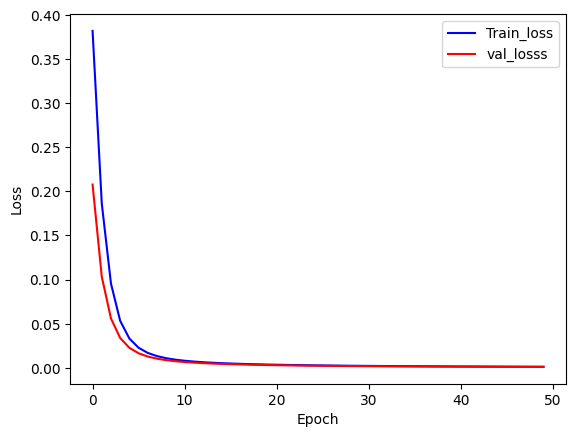

In [239]:
epoch = np.arange(0,num_epochs , 1)
import matplotlib.pyplot as plt

plt.plot(epoch, tr_losses , label="Train_loss", c='b')
plt.plot(epoch, val_losses, label="val_losss", c='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

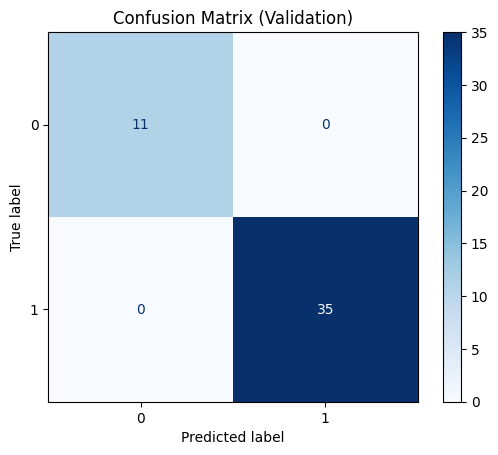

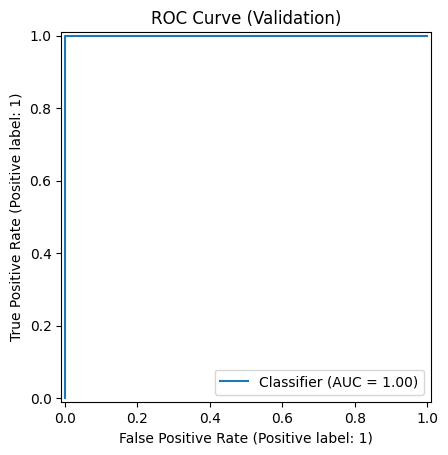

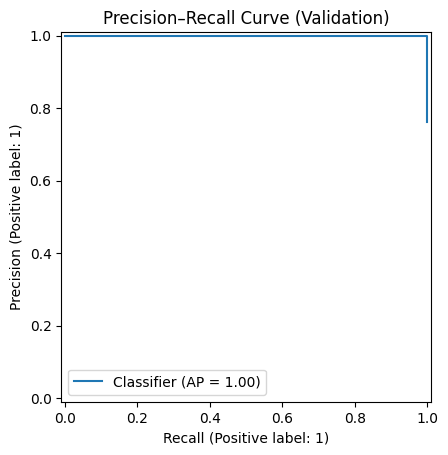

In [240]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B,2]

        # 1) Probability of class 1
        probs  = torch.softmax(logits, dim=1)          # [B,2]
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist())

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# 2) ROC
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve (Validation)")
plt.show()

# 3) Precision–Recall
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision–Recall Curve (Validation)")
plt.show()

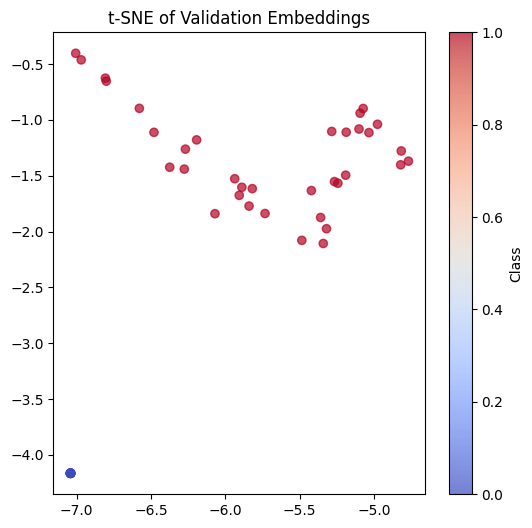

In [241]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()